We start by initializing our LLM. 

In [ ]:
# from langchain_ollama import OllamaLLM

# # For normal, accurate responses (low temperature)
# llm = OllamaLLM(model="llama3:instruct", temperature=0.0)

# # For unique, creative responses (higher temperature)
# creative_llm = OllamaLLM(model="llama3:instruct", temperature=0.9)


In [58]:
import os
from getpass import getpass

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY") or getpass(
    "Enter GOOGLE API Key: "
)


In [75]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",       # choose appropriate model name
    temperature=0.0,
     google_api_key=os.getenv("GOOGLE_API_KEY")
    # you may add other parameters like max_tokens, etc.
)

creative_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",       # choose appropriate model name
    temperature=0.9,
     google_api_key=os.getenv("GOOGLE_API_KEY")
    # you may add other parameters like max_tokens, etc.
)

We will be taking an `article` _draft_ and using LangChain to generate various useful items around this article. We'll be creating:

1. An article title
2. An article description
3. Editor advice where we will insert an additional paragraph in the article
4. A thumbnail / hero image for our article.

In [60]:
article = """

Spider-Man swings into AGE OF REVELATION in this week's Marvel Comics!

Unfriendly and unstable! X years later, the X-Virus decimated New York—but Spider-Man won't stop fighting in RADIOACTIVE SPIDER-MAN (2025) #1 by Joe Kelly and Kev Walker. In a desperate gamble, Peter Parker doses himself with lethal radiation to hold the infection at bay. Survival comes at a cost. While this may not kill Peter Parker, it sure messes him up. This is the most dangerous, mutated Spider-Man ever—and he's not alone.

Behold Peter Parker's next evolution in RADIOACTIVE SPIDER-MAN (2025) #1, on sale this Wednesday, October 22!

RADIOACTIVE SPIDER-MAN (2025) #1 cover by Giuseppe Camuncoli
RADIOACTIVE SPIDER-MAN (2025) #1 cover by Giuseppe Camuncoli
AGE OF REVELATION rages on in Jed MacKay and Netho Diaz's X-MEN: BOOK OF REVELATION (2025) #1, where the Game of Power commences! X years later, after the assassination of one of his prized Choristers, Revelation welcomes a new mutant to his capital city of Philadelphia. But the capital of the Revelation Territories hides many dangers, not the least of which are her rival Choristers—and Fabian Cortez will allow no one to challenge him for Revelation's favor. But this new mutant has a secret ally—the Ghost of Philadelphia!

What happened to Wolverine? X years later, in THE LAST WOLVERINE (2025) #1 by Saladin Ahmed and Edgar Salazar, the people of Vancouver cheer a new hero: the Wonderful Wolverine, AKA the Wendigo, Logan's last student. But what happened to Logan? A secret from Wolverine's past will set the Last Wolverine on a mission to uphold his mentor's legacy… unless a dire threat burns it all down first!

Elsewhere, Kid Omega's all grown up for Tony Fleecs and Andres Genolet's OMEGA KIDS (2025) #1! X years later, Quentin Quire protects the dream of mutant supremacy and independence as head of the Revelation Territories' spy network. But when a conspiracy threatens the mutant utopia, Quire and his psychic students will have to distinguish friend from foe. Has Quentin got what it takes to carry the dream forward, or will the next generation replace the former revolutionary?

Over in the new Ultimate Universe, Miles Morales faces a showdown with the Maker's Council for ULTIMATE SPIDER-MAN: INCURSION (2025) #5 by Deniz Camp, Cody Ziglar, and Jonas Scharf! The clock is ticking for Miles to escape the Ultimate Universe with his baby sister! How will Miles leave a mark on the Ultimate Universe? And how will the Ultimate Universe leave a mark on Miles?! Don't miss the exciting conclusion…and what it bodes for the future of both universes!

Meanwhile, now that the Ultimates are using the Immortus Engine to its full capacity, Doom's dream of the Ultimate Fantastic Four may finally be realized in Deniz Camp and Phil Noto's ULTIMATES (2024) #17. 

Then, as the Ultimate Universe hurtles towards its conclusion, behold the last will and testament of [REDACTED] in ULTIMATE SPIDER-MAN (2024) #22 by Jonathan Hickman and Marco Checchetto!

See Spider-Man's radioactive evolution, meet the Last Wolverine, escape the Ultimate Universe with Miles Morales, and more by picking up the latest titles this week! From fresh comics to collections and even Marvel Unlimited, find the full list of new releases here!
"""


## Preparing our Prompts

Prompts for chat agents are at a minimum broken up into three components, those are:

* System prompt: this provides the instructions to our LLM on how it must behave, what it's objective is, etc.

* User prompt: this is a user written input.

* AI prompt: this is the AI generated output. When representing a conversation, previous generations will be inserted back into the next prompt and become part of the broader _chat history_.

```
You are a helpful AI assistant, you will do XYZ.    | SYSTEM PROMPT

User: Hi, what is the capital of Australia?         | USER PROMPT
AI: It is Canberra                                  | AI PROMPT
User: When is the best time to visit?               | USER PROMPT
```

LangChain provides us with _templates_ for each of these prompt types. By using templates we can insert different inputs to the template, modifying the prompt based on the provided inputs.

In [61]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template(template = "You are an AI assistant called {name} that helps generate article titles.")

# The user prompt, parameterized over "article"
user_prompt = HumanMessagePromptTemplate.from_template(template= """You are tasked with creating a name for an article.
The article is here for you to examine: {article}

The name should be based on the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided."""
)

# Combine prompts using ChatPromptTemplate
first_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])


In [62]:
print(first_prompt.input_variables)

['article', 'name']


In [63]:
print(user_prompt.format(article = "Test Article"))

content='You are tasked with creating a name for an article.\nThe article is here for you to examine: Test Article\n\nThe name should be based on the context of the article.\nBe creative, but make sure the names are clear, catchy,\nand relevant to the theme of the article.\n\nOnly output the article name, no other explanation or\ntext can be provided.' additional_kwargs={} response_metadata={}


In [64]:
formatted = first_prompt.format_messages(article=" Test Article", name = "Jarvis")

for msg in formatted:
    print(f"{msg.type.capitalize()}: {msg.content}")

System: You are an AI assistant called Jarvis that helps generate article titles.
Human: You are tasked with creating a name for an article.
The article is here for you to examine:  Test Article

The name should be based on the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.


`ChatPromptTemplate` also prefixes each individual message with it's role, ie `System:`, `Human:`, or `AI:`.

We can chain together our `first_prompt` template and the `llm` object we defined earlier to create a simple LLM chain. This chain will perform the steps **prompt formatting > llm generation > get output**.

We'll be using **L**ang**C**hain **E**xpression **L**anguage (LCEL) to construct our chain. We define our inputs with the first dictionary segment (ie `{"article": lambda x: x["article"]}`) and then we use the pipe operator (`|`) to say that the output from the left of the pipe will be fed into the input to the right of the pipe.

In [73]:
chain_one_creativeLLM = (
    {"article": lambda x: x["article"], "name": lambda x: x["name"]} | first_prompt | creative_llm | {"article_title": lambda x: x.content}
)

In [74]:
article_title_msg = chain_one_creativeLLM.invoke({"article": article, "name": "Jarvis"})
print(article_title_msg)


{'article_title': 'This Week in Marvel Comics: Revelation, Mutation, and Ultimate Ends'}


In [76]:
chain_one_LLM = (
    {"article": lambda x: x["article"], "name": lambda x: x["name"]} | first_prompt | llm | {"article_title": lambda x: x}
)

In [77]:
article_title_msg_llm = chain_one_LLM.invoke({"article": article, "name": "Jarvis"})
print(article_title_msg)

{'article_title': 'This Week in Marvel Comics: Revelation, Mutation, and Ultimate Ends'}


In [78]:
second_system_prompt = SystemMessagePromptTemplate.from_template( "You are an AI assistant that helps build good articles.")

second_user_prompt = HumanMessagePromptTemplate.from_template(
    '''You are tasked with creating a description for
the article. The article is here for you to examine: {article}

Here is the article title: '{article_title}'.

Output the SEO friendly article description, make sure we don't exceed 150 characters. Do not output
anything other than the description.""",'''
)

second_prompt = ChatPromptTemplate([second_system_prompt, second_user_prompt])

In [81]:
chain_two_LLM = (
    {"article": lambda x: x["article"], "article_title": lambda x: x["article_title"]} | second_prompt | llm | {"summary": lambda x: x.content}
)

In [82]:
article_description_msg = chain_two_LLM.invoke({
    "article": article, "article_title": article_title_msg['article_title']
})
print(article_description_msg)

{'summary': "Explore Radioactive Spider-Man, the Last Wolverine, X-Men's Age of Revelation, and Ultimate Universe conclusions. New Marvel Comics out this week!"}


We create a pydantic object describing the output format we need. This format description is then passed to our model using the with_structured_output method:

In [83]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

# Define your output structure
class Paragraph(BaseModel):
    original_paragraph: str = Field(description = "The original paragraph")
    edited_paragraph: str = Field(description = "The improved edited paragraph")
    feedback: str = Field(description = "Constructive feedback on the original paragraph")

structured_llm = creative_llm.with_structured_output(Paragraph)



In [84]:
third_user_promt = HumanMessagePromptTemplate.from_template(
    '''You are tasked with creating a new paragraph for the
article. The article is here for you to examine: 
---

{article}

---
Choose one paragraph to review and edit. During your edit
ensure you provide constructive feedback to the user so they
can learn where to improve their own writing.
'''
)

#Combine prompt with parser format instructions
third_prompt = ChatPromptTemplate.from_messages([second_system_prompt, third_user_promt])


In [89]:
chain_three = (
    {"article": lambda x: x['article']} | third_prompt | structured_llm | {
                                                                            "original_paragraph": lambda x: x.original_paragraph,
                                                                            "edited_paragraph": lambda x: x.edited_paragraph,
                                                                            "feedback": lambda x: x.feedback
                                                                        }
)

In [91]:
result = chain_three.invoke({"article" : article})
print(result)

{'original_paragraph': "Unfriendly and unstable! X years later, the X-Virus decimated New York—but Spider-Man won't stop fighting in RADIOACTIVE SPIDER-MAN (2025) #1 by Joe Kelly and Kev Walker. In a desperate gamble, Peter Parker doses himself with lethal radiation to hold the infection at bay. Survival comes at a cost. While this may not kill Peter Parker, it sure messes him up. This is the most dangerous, mutated Spider-Man ever—and he's not alone.", 'edited_paragraph': 'In a New York decimated by the X-Virus X years ago, Spider-Man confronts a grim future in RADIOACTIVE SPIDER-MAN (2025) #1 by Joe Kelly and Kev Walker. To combat the pervasive infection, Peter Parker makes a desperate gamble, exposing himself to lethal radiation. This act ensures his survival but transforms him into the most dangerous and mutated Spider-Man ever, a formidable hero who, it seems, is not alone in his struggle.', 'feedback': "1.  **Opening Hook:** The initial exclamation 'Unfriendly and unstable!' is q

In [108]:
os.environ["HUGGINGFACE_API_TOKEN"] = os.getenv("HUGGINGFACE_API_TOKEN") or getpass(
    "Enter HUGGINGFACE API TOKEN: "
)

In [ ]:
from langchain_core.prompts import PromptTemplate

image_prompt = PromptTemplate(template = ("Generate a prompt with less then 500 characters to generate an image based on the following article: {article}"))

The `generate_and_display` function will generate the article image once we have the prompt from our image prompt.

In [ ]:
import matplotlib.pyplot as plt
from langchain_core.runnables import RunnableLambda
from huggingface_hub import InferenceClient

# Setup the HF Inference Client
client = InferenceClient(
    provider="nscale",
    api_key=os.getenv('HUGGINGFACE_API_TOKEN'),
)

# Function to generate and display the image
def generate_and_display_image(prompt: str):
   
    image = client.text_to_image(
     "Astronaut riding a horse",
    model="stabilityai/stable-diffusion-xl-base-1.0",
)

    # Display image using matplotlib
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return image  # You can also return image if you want to use it further

# Wrap in RunnableLambda for LangChain usage
image_gen_runnable = RunnableLambda(generate_and_display_image)


In [138]:
chain_four = (
    {"article": lambda x: x['article']} | image_prompt | llm | (lambda x: x.content) | image_gen_runnable
)

In [136]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="nscale",
    api_key=os.getenv('HUGGINGFACE_API_TOKEN'),
)

# output is a PIL.Image object
image = client.text_to_image(
    "Astronaut riding a horse",
    model="stabilityai/stable-diffusion-xl-base-1.0",
)

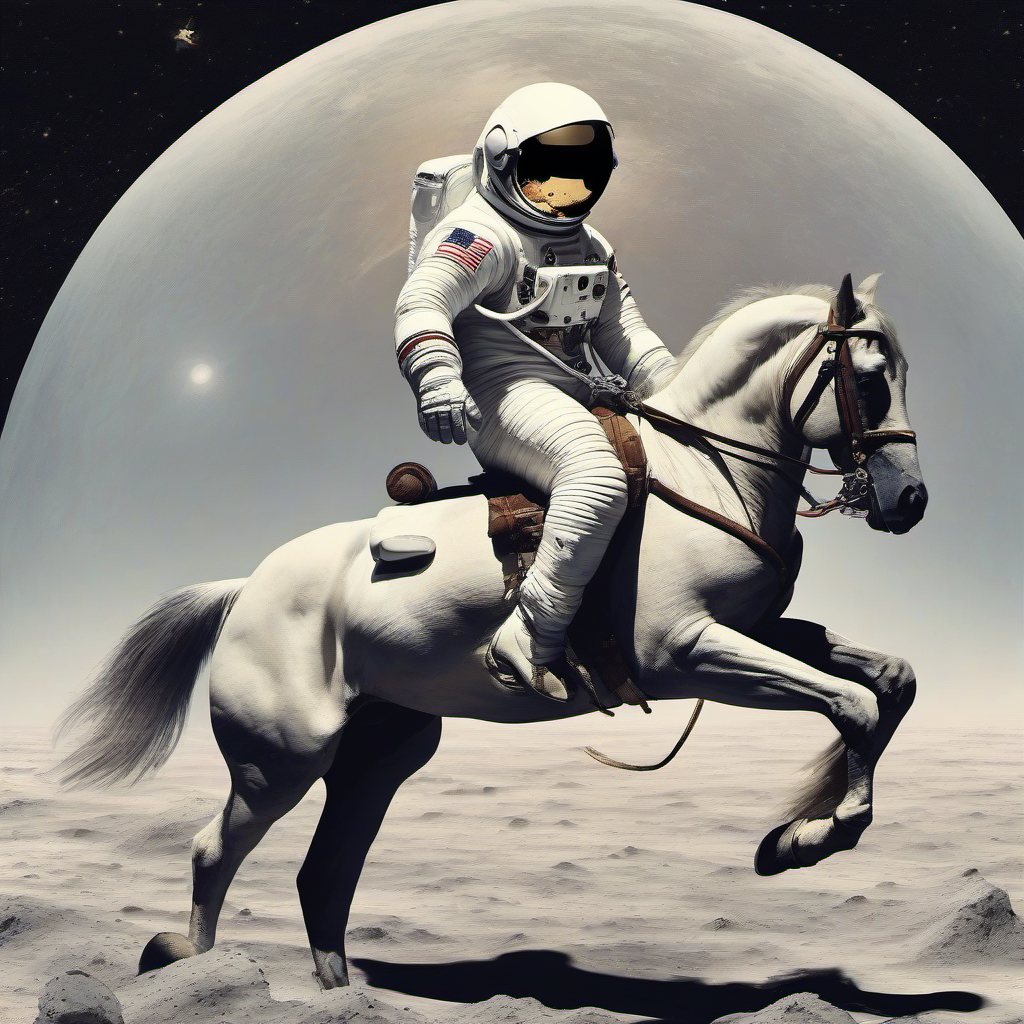

In [140]:
image

In [139]:
chain_four.invoke({"article": article})

ValueError: Model CompVis/stable-diffusion-v1-4 is not supported by provider nscale.